This notebook uses a lot of techniques that are cleverly used in https://www.kaggle.com/bminixhofer/aggregated-features-lightgbm

Since we don't have any overlap of item_id between train and periods data, we use train_active to infere some aggregate features about the users available in the train data (about the other items they have had listed)

In [10]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3 # requires pip install matplotlib_venn
from utils import featurize_date_col

sns.set()
%matplotlib inline
pd.options.mode.chained_assignment = None

In [4]:
# user inputs:
SEED = 13
np.random.seed(SEED)
KEEP_ROWS_FRAC = 0.001 #0.05 # set to 1 if all rows are meant to be kept
skiprows_func = lambda i: i>0 and np.random.rand() > KEEP_ROWS_FRAC

In [5]:
used_cols = ['item_id', 'user_id']

train = pd.read_csv('data/train.csv', usecols=used_cols, skiprows=skiprows_func)
train_active = pd.read_csv('data/train_active.csv', usecols=used_cols, skiprows=skiprows_func)
test = pd.read_csv('data/test.csv', usecols=used_cols, skiprows=skiprows_func)
test_active = pd.read_csv('data/test_active.csv', usecols=used_cols, skiprows=skiprows_func)
train_periods = pd.read_csv('data/periods_train.csv', parse_dates=['date_from', 'date_to', 'activation_date'], infer_datetime_format=True, skiprows=skiprows_func)
test_periods = pd.read_csv('data/periods_test.csv', parse_dates=['date_from', 'date_to', 'activation_date'], infer_datetime_format=True, skiprows=skiprows_func)

train and train_active are connected via user_id and for those users, the corresponding item_id can be found in train_periods

In [6]:
train_periods.iloc[:2]

,item_id,activation_date,date_from,date_to
0,ddf182f513d3,2017-03-21,2017-03-21,2017-03-28
1,d9b548e37b45,2017-03-13,2017-03-15,2017-03-28


In [7]:
def empty_text_func(x):
    return ''
fontdict = {'fontsize': 17,
           'color': 'w',
           'backgroundcolor': 'k',
           'weight': 'bold',
           'style': 'italic'}

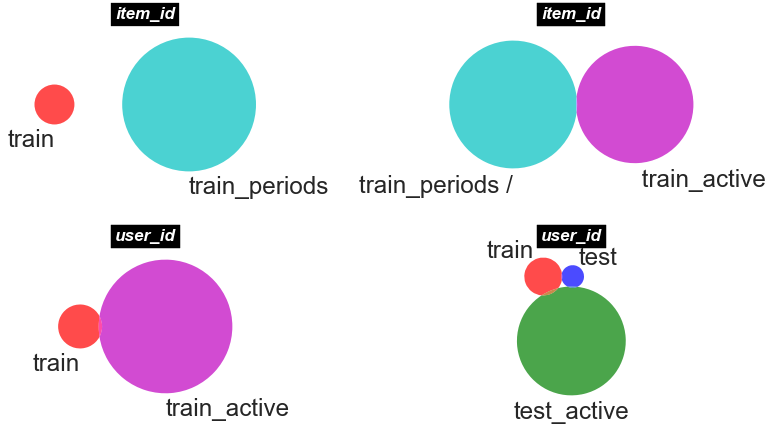

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
plt.subplots_adjust(hspace=0.4)
colors = {'train': 'r', 'test': 'b', 'train_active': 'm', 'train_periods': 'c', 'test_active': 'g'}
axes[0, 0].set_title('item_id', fontdict=fontdict)
# sns.reset_orig()
# sns.reset_defaults()
import seaborn as sns
sns.set_context("poster", font_scale=1.05)
v1 = venn2([set(train['item_id']), set(train_periods['item_id'])], subset_label_formatter=empty_text_func,
     set_labels= ['train', 'train_periods'], normalize_to=1.0, alpha=0.7,
      set_colors=(colors['train'], colors['train_periods']), ax=axes[0, 0]);

axes[0, 1].set_title('item_id', fontdict=fontdict)
v2 = venn2([set(train_periods['item_id']), set(train_active['item_id'])], subset_label_formatter=empty_text_func,
     set_labels= ['train_periods /', ' train_active'], normalize_to=1.0, alpha=0.7,
      set_colors=(colors['train_periods'], colors['train_active']), ax=axes[0, 1]);

axes[1, 0].set_title('user_id', fontdict=fontdict)
v3 = venn2([set(train['user_id']), set(train_active['user_id'])], subset_label_formatter=empty_text_func,
     set_labels= ['train', 'train_active'], normalize_to=1.0, alpha=0.7,
      set_colors=(colors['train'], colors['train_active']), ax=axes[1, 0]);

axes[1, 1].set_title('user_id', fontdict=fontdict)
v4 = venn3([set(train['user_id']), set(test['user_id']), set(test_active['user_id'])], subset_label_formatter=empty_text_func,
     set_labels= ['train', 'test', 'test_active'], normalize_to=1.0, alpha=0.7,
      set_colors=(colors['train'], colors['test'], colors['test_active']), ax=axes[1, 1]);

In [12]:
all_samples = pd.concat([
    train,
    train_active,
    test,
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True) # here we assume each item was published only once?
del train_active
gc.collect()

all_samples = pd.concat([
    all_samples,
    test_active
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True) # here we assume each item was published only once?
    
del test_active
gc.collect()

21

In [13]:
all_periods = pd.concat([
    train_periods,
    test_periods
])

del train_periods
del test_periods
gc.collect()

32

In [14]:
null_idx = all_periods['activation_date'].isna()
all_periods['activation_date'][null_idx] = all_periods['date_from'][null_idx]

In [15]:
assert (all_periods['date_to'] >= all_periods['date_from']).all()

In [16]:
all_periods['days_to_publish'] = all_periods['date_from'].dt.dayofyear - all_periods['activation_date'].dt.dayofyear

In [17]:
all_periods['days_online'] = all_periods['date_to'].dt.dayofyear - all_periods['date_from'].dt.dayofyear

In [18]:
for col in ['activation_date', 'date_from', 'date_to']:
    all_periods = featurize_date_col(all_periods, col, remove_when_done=False)

In [19]:
grouped = all_periods.groupby('item_id')

In [20]:
base = grouped[['item_id']].count().rename(columns={'item_id': 'nlisted'})

In [21]:
base['sum_days_online'] = grouped[['days_online']].sum()
base['mean_days_online'] = grouped[['days_online']].mean()
base['last_days_online'] = grouped[['days_online']].last()
base['sum_days_to_publish'] = grouped[['days_to_publish']].sum()
base['mean_days_to_publish'] = grouped[['days_to_publish']].mean()
base['median_date_to_isholiday'] = grouped[['date_to_isholiday']].median()
base['median_date_to_wday'] = grouped[['date_to_wday']].median()
base['median_date_to_yday'] = grouped[['date_to_yday']].median()
base['start_date'] = grouped[['date_from']].min()
base['end_date'] = grouped[['date_to']].max()
for col in ['start_date', 'end_date']:
    base = featurize_date_col(base, col, remove_when_done=True)

In [22]:
if 'item_id' not in all_periods:
    all_periods = all_periods.reset_index()
if 'item_id' not in base:
    base = base.reset_index()
all_periods = all_periods.drop_duplicates(['item_id'])
all_periods = all_periods.merge(base, on='item_id', how='left')

In [23]:
all_periods = all_periods.merge(all_samples, on='item_id', how='left')

In [24]:
avg_per_user_periods = all_periods.drop(['item_id', 'activation_date', 'date_from', 'date_to'], axis=1).groupby('user_id').mean()

In [25]:
avg_per_user_periods['nitems'] = all_periods[['user_id', 'item_id']].groupby('user_id').count()

In [26]:
avg_per_user_periods.head()

,days_to_publish,days_online,activation_date_isholiday,activation_date_wday,activation_date_yday,date_from_isholiday,date_from_wday,date_from_yday,date_to_isholiday,date_to_wday,...,median_date_to_isholiday,median_date_to_wday,median_date_to_yday,start_date_isholiday,start_date_wday,start_date_yday,end_date_isholiday,end_date_wday,end_date_yday,nitems
user_id,,,,,,,,,,,,,,,,,,,,,
04e6d0ad2409,15,6,0,1,87,0,2,102,0,1,...,0,1.0,108.0,0,2,102,0,1,108,1
06c5ab460456,23,7,0,0,51,0,2,74,0,2,...,0,2.0,81.0,0,2,74,0,2,81,1
19f335a91fcb,6,13,0,3,68,0,2,74,0,1,...,0,1.0,87.0,0,2,74,0,1,87,1
1a03ef0c7cd9,18,6,0,5,84,0,2,102,0,1,...,0,1.0,108.0,0,2,102,0,1,108,1
1a7c83c78e95,10,2,0,6,92,0,2,102,0,4,...,0,4.0,104.0,0,2,102,0,4,104,1


In [ ]:
avg_per_user_periods.to_csv('data/periods_aggregate_features.csv')